# Prepare tensorflow-model-optimization

In [1]:
! pip uninstall -y tensorflow
! pip uninstall -y tf-nightly
! pip install -U tensorflow-gpu==1.14.0

! pip install tensorflow-model-optimization

Uninstalling tensorflow-1.15.0:
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 377.0MB 41kB/s 
     |████████████████████████████████| 3.2MB 48.2MB/s 
     |████████████████████████████████| 491kB 42.3MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
     |████████████████████████████████| 102kB 4.1MB/s 


In [1]:
%load_ext tensorboard
import tensorboard
import tensorflow as tf
tf.enable_eager_execution()

import tempfile
import zipfile
import os

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

#Download dataset from Google Drive

In [2]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#https://drive.google.com/open?id=1swPiOWtQ80zWHOK0pyWDuhilhRDkFux8/view?usp=sharing
#https://drive.google.com/open?id=1swPiOWtQ80zWHOK0pyWDuhilhRDkFux8
download = drive.CreateFile({'id': '1swPiOWtQ80zWHOK0pyWDuhilhRDkFux8'})
download.GetContentFile('weed_dataset_w25.hdf5')

# Read Dataset

In [0]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from operator import truediv
import h5py
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, cohen_kappa_score, confusion_matrix

import tensorboard
import tensorflow as tf
tf.enable_eager_execution()

import tempfile
import zipfile
import os


In [72]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
LOAD HDF5 FILE
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

hdf5_file = h5py.File('weed_dataset_w25.hdf5', "r")
train_x = np.array(hdf5_file["train_img"][...])
# train_x = train_x / np.max(train_x)
# train_x = np.clip(train_x, 0, 1)
#train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], train_x.shape[2], train_x.shape[3], 1))
train_y = np.array(hdf5_file["train_labels"][...])

# Average consecutive bands
img2 = np.zeros((train_x.shape[0], train_x.shape[1], train_x.shape[2], int(train_x.shape[3]/2)))
for n in range(0, train_x.shape[0]):
    # Average consecutive bands
    for i in range(0, train_x.shape[3], 2):
        img2[n, :, :, int(i/2)] = (train_x[n, :, :, i] + train_x[n, :, :, i + 1]) / 2.

train_x = img2

print(train_x.shape)
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], train_x.shape[2], train_x.shape[3], 1))

(6316, 25, 25, 150)


# Calculate loss after removing one spectral band

In [73]:
data = 'WEED'
windowSize = train_x.shape[1]
classes = 3

tf.keras.backend.clear_session()
# Load trained pruned network
loaded_model = tf.keras.models.load_model("Kochia_hyper3DNet_pruned.h5")
loaded_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        optimizer='adadelta',
        metrics=['accuracy'])

In [74]:
import pickle
tf.keras.backend.set_learning_phase(0)
epochs = 10
ntrain = 1

ytest = tf.keras.utils.to_categorical(train_y).astype(np.int32)

SA = np.zeros((train_x.shape[3],))

ypred1 = loaded_model.predict(train_x)
loss1 = tf.keras.losses.categorical_crossentropy(ytest, ypred1)
print(np.sum(ypred1*ytest)/len(ytest))
for nchannel in range(0, train_x.shape[3]):
  print("\n Analyzing channel " +str(nchannel) + "\n" )
  xtest = train_x.copy()
  xtest[:, :, :, nchannel, :] = np.zeros((train_x.shape[0], train_x.shape[1], train_x.shape[2], 1))
  ypred2 = loaded_model.predict(xtest)
  loss2 = tf.keras.losses.categorical_crossentropy(ytest, ypred2)
  print(np.sum(ypred2*ytest)/len(ytest))
  SA[nchannel] = np.sum(abs(loss2 - loss1))

  with open('SA_channel'+str(nchannel), 'wb') as f:
    pickle.dump(SA, f)


0.999169001878346

 Analyzing channel 0

0.6985452390587142

 Analyzing channel 1

0.26818032828247024

 Analyzing channel 2

0.2354829123832933

 Analyzing channel 3

0.2908135655115134

 Analyzing channel 4

0.5621097158981817

 Analyzing channel 5

0.6452628836938537

 Analyzing channel 6

0.6327408701803591

 Analyzing channel 7

0.6862235527632213

 Analyzing channel 8

0.5197479520466196

 Analyzing channel 9

0.20052878046434172

 Analyzing channel 10

0.19795653409135788

 Analyzing channel 11

0.48675704011447957

 Analyzing channel 12

0.464578490175446

 Analyzing channel 13

0.5919760607950842

 Analyzing channel 14

0.607741802539716

 Analyzing channel 15

0.4028707988030419

 Analyzing channel 16

0.5577766698987121

 Analyzing channel 17

0.633621860790613

 Analyzing channel 18

0.5379808469731023

 Analyzing channel 19

0.6010214179991534

 Analyzing channel 20

0.37547707261370955

 Analyzing channel 21

0.4596816949208099

 Analyzing channel 22

0.5318167219833567



In [83]:
list_importance = list(zip(SA, range(0, 150)))
sortedlist = sorted(list_importance, key = lambda x: x[0], reverse=True)
print('\n\nPrinting saliency and spectral band')
for x in sortedlist: 
    print("Spectral band: " + str(x[1]) + "\tSaliency: " + str(x[0])) 



Printing saliency and spectral band
Spectral band: 36	Saliency: 82089.5
Spectral band: 37	Saliency: 82089.5
Spectral band: 106	Saliency: 82074.984375
Spectral band: 105	Saliency: 82073.3828125
Spectral band: 114	Saliency: 82067.8984375
Spectral band: 113	Saliency: 82055.578125
Spectral band: 131	Saliency: 82032.3359375
Spectral band: 10	Saliency: 81320.0546875
Spectral band: 144	Saliency: 81296.984375
Spectral band: 143	Saliency: 81197.9375
Spectral band: 121	Saliency: 81050.15625
Spectral band: 9	Saliency: 80802.09375
Spectral band: 101	Saliency: 80750.65625
Spectral band: 107	Saliency: 78979.046875
Spectral band: 122	Saliency: 77152.15625
Spectral band: 132	Saliency: 76973.28125
Spectral band: 43	Saliency: 76287.4375
Spectral band: 111	Saliency: 76177.6171875
Spectral band: 66	Saliency: 73835.046875
Spectral band: 55	Saliency: 73312.65625
Spectral band: 2	Saliency: 72819.109375
Spectral band: 35	Saliency: 70886.59375
Spectral band: 73	Saliency: 69047.4296875
Spectral band: 61	Salie

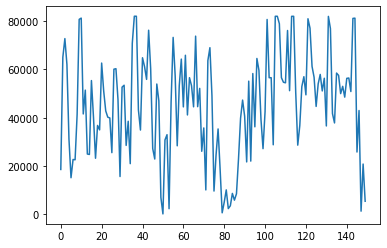

In [75]:
import matplotlib.pyplot as plt
plt.plot(SA)